In [207]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
from astroquery.vizier import Vizier
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter

## Selecting SDSS/BOSS cross-matched

In [2]:
sdss = pd.read_csv('/home/iago.dias/SDSS-BOSS.csv')

In [3]:
sdss = sdss[sdss['f_zsp']<40]

In [4]:
sdss = sdss[['RA_ICRS','DE_ICRS','zsp']]
sdss.columns = ['ra','dec','z']

In [5]:
sdss['survey']='SDSS/BOSS'

In [6]:
sdss = sdss[(sdss['ra']>35) & (sdss['ra']<37.5) & (sdss['dec']<-3.5)& (sdss['dec']>-5.7)] 

In [7]:
sdss

,ra,dec,z,survey
229,37.255031,-5.688772,0.95767,SDSS/BOSS
237,37.290464,-5.670331,0.33875,SDSS/BOSS
238,37.437218,-5.675375,0.48237,SDSS/BOSS
239,37.413628,-5.640567,0.08701,SDSS/BOSS
240,37.390754,-5.624758,0.98790,SDSS/BOSS
...,...,...,...,...
1712,35.285733,-3.539826,0.57483,SDSS/BOSS
1713,35.278646,-3.524045,0.55166,SDSS/BOSS
1715,35.510182,-3.567297,0.43385,SDSS/BOSS
1724,35.814534,-3.506449,0.61090,SDSS/BOSS


In [230]:
xlim = [35, 37.6]
ylim = [-5.7, -3.5]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 limit {l}"





In [231]:
db = DBBase()

In [232]:
%%time
df_phot = db.fetchall_df(query)
df_phot

CPU times: user 6.35 s, sys: 1.05 s, total: 7.41 s
Wall time: 2min 44s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,35.007487,-5.699908,35.007487,-5.699908,2,26.686527,25.948038,25.431511,24.791912,23.509333,0.753584,0.458936,0.480496,0.543438,0.487275
1,35.007206,-5.698918,35.007206,-5.698918,2,27.243288,27.874516,25.645271,24.257034,23.200809,1.591974,3.312021,0.700980,0.406555,0.448916
2,35.014199,-5.699963,35.014199,-5.699963,3,24.688322,22.845715,21.725687,21.233761,20.832272,0.302786,0.071784,0.041562,0.056253,0.121213
3,35.005710,-5.697600,35.005710,-5.697600,2,25.376404,25.182186,24.695261,23.899033,23.668526,0.403480,0.419228,0.461975,0.438974,1.204582
4,35.005364,-5.696071,35.005364,-5.696071,2,24.941610,24.038229,23.319973,22.473572,21.917591,0.474679,0.282959,0.246103,0.229174,0.446646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478057,37.596972,-3.503949,37.596972,-3.503949,2,28.127264,25.018057,24.558380,23.124821,24.091845,3.914046,0.292783,0.382538,0.181597,1.397011
478058,37.590642,-3.501616,37.590642,-3.501616,2,25.212179,24.898882,25.434877,27.766800,24.401665,0.201906,0.196547,0.658452,10.089209,1.204927
478059,37.596333,-3.501956,37.596333,-3.501956,2,24.835213,24.393511,24.042221,24.025785,22.998522,0.222992,0.185367,0.280440,0.491143,0.603241
478060,37.599093,-3.512776,37.599093,-3.512776,3,22.987028,21.334810,20.564507,20.187857,20.096292,0.059058,0.017016,0.016643,0.020837,0.060350


In [233]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=sdss['ra'], dec=sdss['dec'], unit=(u.deg, u.deg))


CPU times: user 1min 5s, sys: 395 ms, total: 1min 6s
Wall time: 1min 6s


In [234]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
sdss_matched = df_phot.iloc[idx2]
zspec = sdss.iloc[idx1]['z'].values

sdss_matched['z'] = zspec



/tmp/ipykernel_9497/4229036883.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matched['z'] = zspec


In [235]:
sdss_matched['survey']='SDSS/BOSS'

/tmp/ipykernel_9497/249163995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matched['survey']='SDSS/BOSS'


In [236]:
sdss_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
347081,37.255029,-5.688740,37.255029,-5.688740,3,22.149763,22.024118,21.480795,21.265371,21.381197,0.024116,0.029117,0.031689,0.050407,0.187459,0.95767,SDSS/BOSS
357302,37.290511,-5.670288,37.290511,-5.670288,3,20.368042,18.719124,18.175367,17.871948,17.735844,0.012804,0.003618,0.003889,0.005722,0.016731,0.33875,SDSS/BOSS
347462,37.437240,-5.675342,37.437240,-5.675342,3,21.848080,20.027540,19.321104,18.867994,18.668270,0.040691,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS
359507,37.413654,-5.640530,37.413654,-5.640530,3,17.227966,16.316692,15.940803,15.656432,15.529766,0.001460,0.000828,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS
359588,37.390743,-5.624734,37.390743,-5.624734,3,22.256493,21.933615,21.404972,21.240953,21.167528,0.024575,0.023864,0.026510,0.043123,0.133044,0.98790,SDSS/BOSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260310,35.285689,-3.539843,35.285689,-3.539843,3,21.766348,20.213488,19.387247,18.973791,18.866899,0.029791,0.010394,0.008991,0.011265,0.030233,0.57483,SDSS/BOSS
260371,35.278654,-3.524113,35.278654,-3.524113,3,21.742535,19.765615,18.933088,18.531687,18.472466,0.032502,0.007749,0.006445,0.007658,0.021189,0.55166,SDSS/BOSS
261943,35.510185,-3.567325,35.510185,-3.567325,3,21.693323,20.039982,19.464895,19.154772,19.030590,0.029494,0.009056,0.009120,0.012940,0.030145,0.43385,SDSS/BOSS
338158,35.814469,-3.506495,35.814469,-3.506495,3,22.180002,20.395002,19.347071,18.906082,18.829689,0.057846,0.016076,0.010689,0.012002,0.029610,0.61090,SDSS/BOSS


## Selecting 2dFRGS cross-matched

In [237]:
two_d = pd.read_csv('/home/iago.dias/2dfgrs.csv')

In [238]:
two_d = two_d[two_d['q_z']>=3]

In [17]:
#two_d = two_d[two_d['SNR']>=10] tirar???

In [239]:
two_d = two_d[['RAJ2000','DEJ2000','z']]
two_d.columns=['ra','dec','z']

In [240]:
two_d['survey']='2dFRGS'

In [241]:
two_d = two_d[(two_d['ra']>51.5) & (two_d['ra']<53.9) & (two_d['dec']<-26.9)& (two_d['dec']>-29.2)] 

In [242]:
two_d

,ra,dec,z,survey
890,52.400792,-29.166583,0.2360,2dFRGS
891,52.488417,-29.188250,0.0715,2dFRGS
892,52.522583,-29.162500,0.2830,2dFRGS
893,52.489458,-29.095500,0.1101,2dFRGS
894,52.453292,-29.074472,0.0712,2dFRGS
...,...,...,...,...
2736,51.899750,-26.946694,0.1489,2dFRGS
2737,51.736708,-26.951944,0.1438,2dFRGS
2738,51.721333,-26.928528,0.1433,2dFRGS
2740,51.819292,-26.903333,0.2023,2dFRGS


In [243]:
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 limit {l}"




'''
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"

'''



'\nxlim = [51.5, 53.9]\nylim = [-29.2, -26.9]\nl = 750000\nquery = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"\n\n'

In [244]:
%%time
df_phot_2 = db.fetchall_df(query)
df_phot_2

CPU times: user 5.23 s, sys: 889 ms, total: 6.12 s
Wall time: 2min 41s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,51.500757,-29.199985,51.500757,-29.199985,2,25.021219,26.378838,26.212328,24.512352,24.305445,0.204695,0.954490,1.357094,0.657117,1.697356
1,51.501295,-29.197553,51.501295,-29.197553,2,26.008503,26.700943,24.245358,23.002577,26.348965,0.904676,2.111422,0.364529,0.271298,18.331192
2,51.506612,-29.197664,51.506612,-29.197664,2,24.539690,23.798536,23.513824,23.372150,23.221254,0.165148,0.108295,0.143995,0.283563,0.764117
3,51.503581,-29.195577,51.503581,-29.195577,2,24.023148,23.150806,22.796436,22.622778,22.532957,0.115007,0.061346,0.077828,0.159305,0.391039
4,51.505463,-29.193003,51.505463,-29.193003,2,24.531452,24.634829,24.086082,23.932009,23.945736,0.136475,0.190459,0.190539,0.399125,1.222297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403370,53.892676,-26.902014,53.892676,-26.902014,3,24.433556,23.454012,23.334606,23.082016,23.534523,0.177227,0.090277,0.172789,0.260900,1.239457
403371,53.893548,-26.902633,53.893548,-26.902633,3,22.569305,22.169346,22.023178,21.548998,22.274689,0.033917,0.029367,0.054446,0.066981,0.408751
403372,53.893577,-26.901409,53.893577,-26.901409,3,23.826723,23.338791,22.970352,22.493290,22.262968,0.096593,0.076093,0.117518,0.141011,0.365163
403373,53.897710,-26.902527,53.897710,-26.902527,3,23.837223,23.074015,22.633101,22.525097,22.539566,0.105286,0.065539,0.093143,0.160717,0.509797


In [245]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=two_d['ra'], dec=two_d['dec'], unit=(u.deg, u.deg))


CPU times: user 56.2 s, sys: 321 ms, total: 56.5 s
Wall time: 56.5 s


In [246]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
two_d_matched = df_phot_2.iloc[idx2]
zspec = two_d.iloc[idx1]['z'].values

two_d_matched['z'] = zspec


/tmp/ipykernel_9497/1018296563.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_d_matched['z'] = zspec


In [247]:
two_d_matched['survey']='2dFRGS'

/tmp/ipykernel_9497/2531596005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_d_matched['survey']='2dFRGS'


In [248]:
two_d_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
6055,51.730250,-29.159197,51.730250,-29.159197,3,18.890404,17.888821,17.488638,17.207067,17.112206,0.002955,0.001547,0.001848,0.003098,0.008942,0.1348,2dFRGS
6252,51.726861,-29.100389,51.726861,-29.100389,3,18.832258,17.866297,17.469213,17.193844,17.095108,0.002278,0.001203,0.001443,0.002203,0.005988,0.1168,2dFRGS
5085,51.696841,-29.006400,51.696841,-29.006400,3,18.454252,17.520678,17.126947,16.858967,16.742199,0.002345,0.001446,0.001760,0.002409,0.008960,0.1104,2dFRGS
31515,52.054073,-29.175033,52.054073,-29.175033,3,17.887152,16.835957,16.419085,16.104586,16.013882,0.002141,0.001120,0.001353,0.001739,0.006322,0.1353,2dFRGS
7995,51.958065,-29.163845,51.958065,-29.163845,3,18.077812,17.412390,17.068445,16.878561,16.803955,0.002057,0.001499,0.002073,0.002829,0.010968,0.1496,2dFRGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217577,51.869277,-27.038115,51.869277,-27.038115,3,18.216961,17.561947,17.258505,17.113890,17.061022,0.002204,0.001572,0.001899,0.003314,0.011871,0.2210,2dFRGS
220616,51.899973,-26.946502,51.899973,-26.946502,3,18.075142,17.309658,16.954515,16.730850,16.650419,0.001843,0.001228,0.001490,0.002580,0.009367,0.1489,2dFRGS
218793,51.736952,-26.951882,51.736952,-26.951882,3,18.326010,17.501541,17.155703,16.918789,16.844782,0.002434,0.001458,0.001655,0.002651,0.010985,0.1438,2dFRGS
218691,51.721499,-26.928319,51.721499,-26.928319,3,17.356909,16.349276,15.953111,15.670392,15.569478,0.001637,0.000858,0.000930,0.001556,0.005874,0.1433,2dFRGS


## Selecting OzDES cross-match

In [249]:
ozdes = pd.read_csv('/home/iago.dias/OzDES.csv')

In [250]:
ozdes = ozdes[ozdes['types']=='Photo-z'] 

In [251]:
ozdes = ozdes[['RAJ2000','DEJ2000','z']]
ozdes.columns = ['ra','dec','z']

In [252]:
ozdes['survey']='OzDES'

In [253]:
ozdes = ozdes[(ozdes['ra']>51.5) & (ozdes['ra']<53.9) & (ozdes['dec']<-26.9)& (ozdes['dec']>-29.2)] 

In [254]:
ozdes


,ra,dec,z,survey
663,52.364000,-29.063611,0.29499,OzDES
665,52.346208,-29.047444,0.46218,OzDES
666,52.396083,-29.010444,0.21749,OzDES
670,52.340125,-29.003250,0.68351,OzDES
671,52.352750,-28.996944,0.40005,OzDES
...,...,...,...,...
5352,53.552708,-27.018139,0.63642,OzDES
5366,53.478083,-26.959389,0.25218,OzDES
5377,53.263625,-27.083000,0.62159,OzDES
5423,53.811417,-26.921611,0.71457,OzDES


In [255]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=ozdes['ra'], dec=ozdes['dec'], unit=(u.deg, u.deg))


CPU times: user 55.8 s, sys: 329 ms, total: 56.2 s
Wall time: 56.2 s


In [256]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
ozdes_matched = df_phot_2.iloc[idx2]
zspec = ozdes.iloc[idx1]['z'].values

ozdes_matched['z'] = zspec


/tmp/ipykernel_9497/2744309778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozdes_matched['z'] = zspec


In [257]:
ozdes_matched['survey']='OzDES'

/tmp/ipykernel_9497/587646815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozdes_matched['survey']='OzDES'


In [258]:
ozdes_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
42399,52.364081,-29.063598,52.364081,-29.063598,3,21.872379,21.204634,20.941463,20.716957,20.862188,0.019739,0.014196,0.020797,0.030582,0.135860,0.29499,OzDES
42237,52.346351,-29.047413,52.346351,-29.047413,3,21.291992,20.458984,20.158737,19.824772,19.539526,0.017564,0.010883,0.014796,0.020341,0.056159,0.46218,OzDES
43076,52.396158,-29.010452,52.396158,-29.010452,3,20.931192,19.781029,19.302427,18.987013,18.862089,0.016878,0.008097,0.009133,0.013398,0.040550,0.21749,OzDES
42689,52.340146,-29.003238,52.340146,-29.003238,3,24.014675,21.947693,20.933828,20.471069,20.311346,0.173799,0.033496,0.023483,0.028881,0.093602,0.68351,OzDES
42989,52.352790,-28.996953,52.352790,-28.996953,3,20.323170,19.225962,18.853956,18.548046,18.512770,0.008102,0.003936,0.004942,0.006943,0.025024,0.40005,OzDES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393137,53.552743,-27.018133,53.552743,-27.018133,3,22.247082,21.135773,20.502247,20.208508,20.062546,0.035119,0.018320,0.019038,0.025469,0.080495,0.63642,OzDES
392951,53.478112,-26.959408,53.478112,-26.959408,3,21.351858,20.625410,20.324642,20.132301,20.138453,0.013876,0.008920,0.012771,0.020135,0.069047,0.25218,OzDES
383639,53.263696,-27.083038,53.263696,-27.083038,3,21.876299,20.946074,20.394661,20.108767,19.970228,0.035056,0.019135,0.022514,0.031080,0.098951,0.62159,OzDES
402591,53.811449,-26.921607,53.811449,-26.921607,3,23.602448,21.813089,20.773027,20.346767,20.302980,0.095374,0.024161,0.018833,0.024319,0.078899,0.71457,OzDES


## Selecting VVDS-DEEP for SN-C3 field and cross-match

In [260]:
vvds_snc3 = pd.read_csv('/home/iago.dias/VVDS-DEEP-SN-C3.csv')

In [261]:
vvds_snc3 = vvds_snc3[(vvds_snc3['f_z']==3) | (vvds_snc3['f_z']==4)]

In [262]:
vvds_snc3 = vvds_snc3[['RAJ2000','DEJ2000','z']]
vvds_snc3.columns = ['ra','dec','z']
vvds_snc3['survey']='VVDS-DEEP_SNC3'

In [263]:
vvds_snc3 = vvds_snc3[(vvds_snc3['ra']>51.5) & (vvds_snc3['ra']<53.9) & (vvds_snc3['dec']<-26.9)& (vvds_snc3['dec']>-29.2)] 

In [264]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snc3['ra'], dec=vvds_snc3['dec'], unit=(u.deg, u.deg))


CPU times: user 56 s, sys: 293 ms, total: 56.3 s
Wall time: 56.3 s


In [265]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snc3_matched = df_phot_2.iloc[idx2]
zspec = vvds_snc3.iloc[idx1]['z'].values

vvds_snc3_matched['z'] = zspec


/tmp/ipykernel_9497/1336483942.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snc3_matched['z'] = zspec


In [266]:
vvds_snc3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z
333217,53.286706,-27.984811,53.286706,-27.984811,3,22.885555,22.217167,22.145771,21.904156,21.562447,0.046603,0.032738,0.060927,0.079103,0.238900,0.3467
332128,53.247478,-27.987065,53.247478,-27.987065,3,25.026497,24.096064,23.688519,22.876402,22.217896,0.255810,0.140685,0.186319,0.150694,0.340404,1.0345
332132,53.250803,-27.982988,53.250803,-27.982988,3,24.444149,22.777306,21.485756,21.053465,20.757029,0.192401,0.053434,0.031655,0.036107,0.111926,0.7323
333292,53.292520,-27.972380,53.292520,-27.972380,3,22.950937,22.229689,22.004982,21.972246,21.978498,0.046543,0.030700,0.049180,0.078952,0.325997,0.5197
333275,53.279024,-27.961066,53.279024,-27.961066,2,23.808512,23.754353,24.381804,23.051592,22.763985,0.098143,0.121461,0.438038,0.214123,0.710239,1.5259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250719,53.060976,-27.635189,53.060976,-27.635189,3,21.260885,20.553328,20.370537,20.112488,20.248232,0.012206,0.008402,0.014201,0.018857,0.091732,0.3272
250295,53.036964,-27.638832,53.036964,-27.638832,3,23.106016,22.539331,22.138922,22.038925,23.397715,0.078851,0.060811,0.076075,0.123214,1.814768,0.6740
250224,53.022457,-27.635440,53.022457,-27.635440,3,22.872257,22.290136,22.190702,22.450642,22.861362,0.051949,0.040210,0.073997,0.172140,0.994070,0.2485
250406,53.040480,-27.629787,53.040480,-27.629787,3,23.036732,22.266546,21.905739,22.112364,21.881971,0.047990,0.030572,0.041672,0.085210,0.301761,0.5575


## Selecting VVDS-DEEP for SN-X3 field

In [267]:
vvds_snx3 = pd.read_csv('/home/iago.dias/VVDS-DEEP-SN-X3.csv')

In [268]:
vvds_snx3 = vvds_snx3[(vvds_snx3['f_z']==3) | (vvds_snx3['f_z']==4)]

In [269]:
vvds_snx3 = vvds_snx3[['RAJ2000','DEJ2000','z']]
vvds_snx3.columns = ['ra','dec','z']
vvds_snx3['survey']='VVDS-DEEP_SNX3'

In [270]:
vvds_snx3 = vvds_snx3[(vvds_snx3['ra']>35.4) & (vvds_snx3['ra']<37.9) & (vvds_snx3['dec']<-3.44)& (vvds_snx3['dec']>-5.73)] 

In [271]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snx3['ra'], dec=vvds_snx3['dec'], unit=(u.deg, u.deg))


CPU times: user 1min 6s, sys: 390 ms, total: 1min 6s
Wall time: 1min 6s


In [272]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snx3_matched = df_phot.iloc[idx2]
zspec = vvds_snx3.iloc[idx1]['z'].values

vvds_snx3_matched['z'] = zspec


/tmp/ipykernel_9497/1015011134.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3_matched['z'] = zspec


In [273]:
vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'

/tmp/ipykernel_9497/929649400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'


In [274]:
vvds_snx3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
184366,36.518960,-4.819177,36.518960,-4.819177,3,22.099041,21.354479,21.198622,21.169971,21.030754,0.028702,0.019255,0.030826,0.056837,0.137146,0.2444,VVDS-DEEP_SNX3
184470,36.560774,-4.821168,36.560774,-4.821168,3,20.901560,20.095232,19.892992,19.644833,19.699436,0.013418,0.008623,0.012344,0.019504,0.059182,0.3826,VVDS-DEEP_SNX3
190457,36.596338,-4.817969,36.596338,-4.817969,3,23.295301,21.644575,20.912897,20.550489,20.514111,0.072464,0.021151,0.019981,0.027077,0.073219,0.5194,VVDS-DEEP_SNX3
190522,36.601075,-4.814174,36.601075,-4.814174,3,24.513222,24.146391,23.556713,23.665051,23.895084,0.181298,0.171516,0.186081,0.388140,1.295122,0.5200,VVDS-DEEP_SNX3
184499,36.581278,-4.819034,36.581278,-4.819034,2,24.514572,24.037298,23.902840,22.944878,22.919243,0.157613,0.132470,0.209533,0.164804,0.433966,0.8025,VVDS-DEEP_SNX3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,36.529195,-4.051856,36.529195,-4.051856,3,23.970829,23.128885,22.021986,21.537502,21.554939,0.125510,0.075660,0.047954,0.071392,0.168510,0.9839,VVDS-DEEP_SNX3
307954,36.429968,-4.059960,36.429968,-4.059960,2,25.257223,24.122269,23.884937,24.088453,24.437765,0.248972,0.113406,0.150168,0.385409,1.324466,0.6913,VVDS-DEEP_SNX3
309374,36.438783,-4.057324,36.438783,-4.057324,3,24.702753,22.872892,22.202976,21.844450,21.811291,0.243529,0.058558,0.052097,0.085259,0.198299,0.4278,VVDS-DEEP_SNX3
309401,36.447076,-4.049981,36.447076,-4.049981,3,23.412895,22.774393,22.617565,22.654896,23.331470,0.078655,0.056495,0.087659,0.191226,0.822601,0.5394,VVDS-DEEP_SNX3


## Selecting ZCOSMOS(?) AND ACES

```sql
SELECT * 
FROM des_dr2.public_specz_compilation 
WHERE survey = 'VVDS' OR survey = 'ZCOSMOS' OR survey = 'ACES'

```

In [45]:
query_spec = "SELECT * FROM des_dr2.public_specz_compilation WHERE survey = 'VVDS' OR survey = 'ZCOSMOS' OR survey = 'ACES'"

In [46]:
df_spec = db.fetchall_df(query_spec)

In [47]:
df_spec

,ra,dec,z,err_z,flag_des,survey,flag_survey,id_spec
0,52.866211,-27.789665,0.680099,0.000126,4,ACES,4.0,9999
1,53.237947,-27.967360,0.355152,0.000009,4,ACES,4.0,9999
2,52.977095,-27.869796,0.863873,0.000146,3,ACES,3.0,9999
3,52.981518,-27.870166,0.645545,0.000080,4,ACES,4.0,9999
4,52.847088,-27.818247,0.966832,0.000233,3,ACES,3.0,9999
...,...,...,...,...,...,...,...,...
30327,149.587280,1.863826,0.241500,99.000000,4,ZCOSMOS,3.0,9999
30328,149.573318,1.867664,0.655400,99.000000,4,ZCOSMOS,3.0,9999
30329,149.573975,1.858701,0.219400,99.000000,4,ZCOSMOS,4.0,9999
30330,149.534622,1.744609,0.384800,99.000000,4,ZCOSMOS,3.0,9999


In [48]:
zcosmos=df_spec[df_spec['survey']=='ZCOSMOS']
aces=df_spec[df_spec['survey']=='ACES']
#vvds=df_spec[df_spec['survey']=='VVDS']

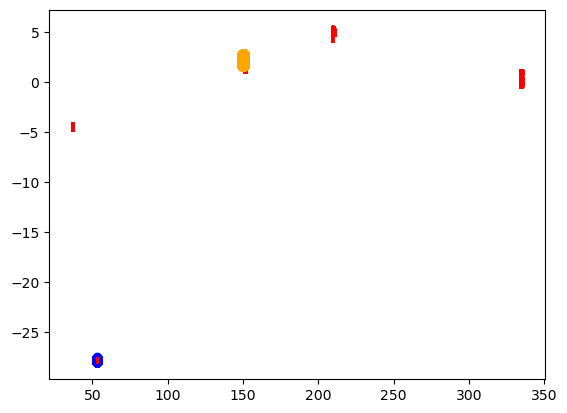

In [49]:
plt.scatter(aces['ra'],aces['dec'],color='blue')
#plt.scatter(vvds['ra'],vvds['dec'],color='red',s=0.5)
plt.scatter(zcosmos['ra'],zcosmos['dec'],color='orange')
#plt.xlim(51,54)
#plt.ylim(-30,-27)

## Selecting ACES AND ZCOSMOS (?) cross-matched

```sql
SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE survey = 'ZCOSMOS' OR survey = 'ACES'
```

In [275]:

query_matched = "SELECT * FROM des_dr2.public_pz_training_set WHERE survey = 'ZCOSMOS' OR survey = 'ACES'"




In [276]:
df_matched = db.fetchall_df(query_matched)

In [277]:


df_matched = df_matched[(df_matched['mag_auto_g_dered']<90) & (df_matched['mag_auto_r_dered']<90) &(df_matched['mag_auto_i_dered']<90) &(df_matched['mag_auto_z_dered']<90) &(df_matched['mag_auto_y_dered']<90)]




In [278]:


#df_matched = df_matched[(df_matched['magerr_auto_g']<0.103) & (df_matched['magerr_auto_r']<0.103) &(df_matched['magerr_auto_i']<0.103) &(df_matched['magerr_auto_z']<0.103) &(df_matched['magerr_auto_y']<0.103)]




In [279]:
df_matched.columns=['coadd_object_id','ra','dec','z','err_z','flag_des','survey','flag','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y']

In [280]:
zcosmos_matched = df_matched[df_matched['survey']=='ZCOSMOS']
aces_matched = df_matched[df_matched['survey']=='ACES']

## Main training sample

In [281]:
training_1 = vvds_snx3_matched.sample(int(len(vvds_snx3_matched)/2))
training_2 = sdss_matched.sample(int(len(sdss_matched)/2)) 
training_3 = aces_matched.sample(int(len(aces_matched)/2))
training_4 = two_d_matched.sample(int(len(two_d_matched)/2))
training_5 = ozdes_matched.sample(int(len(ozdes_matched)/2))

In [282]:
print(len(vvds_snx3_matched))
print(len(sdss_matched))
print(len(aces_matched))
print(len(two_d_matched))
print(len(ozdes_matched))

4302
739
3913
453
744


In [283]:
training = pd.concat([training_2,training_3,training_4,training_5,training_1],axis=0)

In [284]:
training

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
359507,37.413654,-5.640530,37.413654,-5.640530,3.0,17.227966,16.316692,15.940803,15.656432,15.529766,...,0.000828,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS,NaN,NaN,NaN,NaN
457902,37.201099,-3.760855,37.201099,-3.760855,3.0,22.585733,20.788012,19.618750,19.151535,19.022469,...,0.018910,0.011825,0.013813,0.033421,0.71829,SDSS/BOSS,NaN,NaN,NaN,NaN
88360,36.287558,-5.652844,36.287558,-5.652844,3.0,22.234673,20.348242,19.662128,19.281944,19.205530,...,0.008635,0.007829,0.010854,0.033252,0.48565,SDSS/BOSS,NaN,NaN,NaN,NaN
449539,36.884410,-3.787732,36.884410,-3.787732,3.0,22.145147,20.464787,19.620647,19.222317,19.157822,...,0.012401,0.009828,0.013577,0.034969,0.58016,SDSS/BOSS,NaN,NaN,NaN,NaN
182449,36.397179,-4.786826,36.397179,-4.786826,3.0,19.846619,18.349522,17.851353,17.521730,17.373857,...,0.002359,0.002678,0.003756,0.008199,0.25458,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409408,37.000922,-4.511126,37.000922,-4.511126,3.0,22.894587,22.468613,21.807077,21.943567,21.742634,...,0.051070,0.052163,0.112157,0.224808,0.91380,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
159349,36.284585,-4.702133,36.284585,-4.702133,3.0,23.298851,22.465710,22.116976,21.842861,21.735163,...,0.046997,0.072972,0.093828,0.242026,1.11360,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
208632,36.707528,-4.416536,36.707528,-4.416536,3.0,23.924961,23.493694,23.321011,22.761631,22.725483,...,0.113290,0.168442,0.213542,0.497903,0.76430,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
205236,36.686005,-4.486996,36.686005,-4.486996,2.0,25.516062,24.734631,24.217693,24.977180,24.516994,...,0.151179,0.170174,0.706117,1.173787,0.88850,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


## Main testing sample

In [285]:
testing_1 = vvds_snx3_matched.drop(training_1.index)
testing_2 = sdss_matched.drop(training_2.index)
testing_3 = aces_matched.drop(training_3.index)
testing_4 = two_d_matched.drop(training_4.index)
testing_5 = ozdes_matched.drop(training_5.index)

In [286]:
testing = pd.concat([testing_2,testing_3,testing_4,testing_5,vvds_snc3_matched,testing_1],axis=0)

In [287]:
testing

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
347081,37.255029,-5.688740,37.255029,-5.688740,3.0,22.149763,22.024118,21.480795,21.265371,21.381197,...,0.029117,0.031689,0.050407,0.187459,0.95767,SDSS/BOSS,NaN,NaN,NaN,NaN
357302,37.290511,-5.670288,37.290511,-5.670288,3.0,20.368042,18.719124,18.175367,17.871948,17.735844,...,0.003618,0.003889,0.005722,0.016731,0.33875,SDSS/BOSS,NaN,NaN,NaN,NaN
347462,37.437240,-5.675342,37.437240,-5.675342,3.0,21.848080,20.027540,19.321104,18.867994,18.668270,...,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS,NaN,NaN,NaN,NaN
359588,37.390743,-5.624734,37.390743,-5.624734,3.0,22.256493,21.933615,21.404972,21.240953,21.167528,...,0.023864,0.026510,0.043123,0.133044,0.98790,SDSS/BOSS,NaN,NaN,NaN,NaN
356864,37.219842,-5.677816,37.219842,-5.677816,3.0,20.389721,18.815584,18.272215,17.940228,17.810299,...,0.003106,0.003295,0.004647,0.013845,0.29940,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309135,36.456382,-4.088724,36.456382,-4.088724,3.0,24.224846,23.598618,23.355848,23.141249,24.554411,...,0.101441,0.163582,0.245031,2.504702,0.45110,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
309363,36.464173,-4.069781,36.464173,-4.069781,3.0,22.483664,21.429623,21.007992,20.710739,20.797987,...,0.018358,0.022779,0.034247,0.093457,0.32680,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
309406,36.458664,-4.063129,36.458664,-4.063129,3.0,23.987848,23.201448,22.992508,22.755449,22.378445,...,0.063765,0.101793,0.162045,0.293993,0.39540,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
310028,36.529195,-4.051856,36.529195,-4.051856,3.0,23.970829,23.128885,22.021986,21.537502,21.554939,...,0.075660,0.047954,0.071392,0.168510,0.98390,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


## Saving data

In [179]:
del testing['coadd_object_id'], testing['survey'], testing['err_z'], testing['flag'], testing['flag_des'], testing['ra'], testing['dec'], testing['alphawin_j2000'],testing['deltawin_j2000'],testing['extended_class_coadd']
del training['coadd_object_id'], training['survey'], training['err_z'], training['flag'], training['flag_des'], training['ra'], training['dec'], training['alphawin_j2000'],training['deltawin_j2000'],training['extended_class_coadd']


In [181]:
last_column = training.columns[-1]
training = training[[last_column] + [column for column in training.columns if column != last_column]]

last_column2 = testing.columns[-1]
testing = testing[[last_column2] + [column for column in training.columns if column != last_column2]]

In [183]:
g = testing['mag_auto_g']
r = testing['mag_auto_r']
i = testing['mag_auto_i']
z = testing['mag_auto_z']
y = testing['mag_auto_y']
gt = training['mag_auto_g']
rt = training['mag_auto_r']
it = training['mag_auto_i']
zt = training['mag_auto_z']
yt = training['mag_auto_y']

testing['g-r'] = g-r
testing['r-i'] = r-i
testing['i-z'] = i-z
testing['z-y'] = z-y
training['g-r'] = gt-rt
training['r-i'] = rt-it
training['i-z'] = it-zt
training['z-y'] = zt-yt

/tmp/ipykernel_9497/2370129173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['g-r'] = g-r
/tmp/ipykernel_9497/2370129173.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['r-i'] = r-i
/tmp/ipykernel_9497/2370129173.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [185]:
testing.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

In [186]:
testing['eg-r'] = testing['eg']-testing['er']
testing['er-i'] = testing['er']-testing['ei']
testing['ei-z'] = testing['ei']-testing['ez']
testing['ez-y'] = testing['ez']-testing['ey']
training['eg-r'] = training['eg']-training['er']
training['er-i'] = training['er']-training['ei']
training['ei-z'] = training['ei']-training['ez']
training['ez-y'] = training['ez']-training['ey']

/tmp/ipykernel_9497/77383006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['eg-r'] = testing['eg']-testing['er']
/tmp/ipykernel_9497/77383006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['er-i'] = testing['er']-testing['ei']
/tmp/ipykernel_9497/77383006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [189]:
testing.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/testing.sanchez', sep=' ', index = False)
training.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/training.sanchez', sep=' ', index = False)

In [188]:
training

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
5836,0.94867,21.807480,21.373789,20.680782,20.136896,20.061079,0.021597,0.019053,0.018102,0.020806,0.062883,0.433691,0.693007,0.543886,0.075817,0.002544,0.000950,-0.002704,-0.042077
31148,0.51375,20.721071,20.123066,19.498674,19.137478,18.629610,0.008253,0.006769,0.006565,0.008656,0.015118,0.598005,0.624392,0.361197,0.507868,0.001484,0.000203,-0.002091,-0.006462
12278,0.61463,21.396135,20.319326,19.628334,19.285233,19.158482,0.024879,0.012077,0.011305,0.015377,0.031579,1.076809,0.690992,0.343102,0.126751,0.012802,0.000772,-0.004073,-0.016201
6613,0.49723,21.951574,20.155350,19.405920,19.004028,18.972719,0.036949,0.009720,0.008106,0.011283,0.031354,1.796225,0.749430,0.401892,0.031309,0.027229,0.001613,-0.003177,-0.020071
4600,0.55881,22.131300,20.367273,19.555399,19.124153,19.030687,0.052438,0.014273,0.011166,0.013959,0.037265,1.764027,0.811874,0.431246,0.093466,0.038165,0.003107,-0.002793,-0.023306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27974,0.70150,22.228693,21.511717,21.021770,20.810612,20.715675,0.027690,0.019556,0.022271,0.035690,0.085164,0.716976,0.489946,0.211159,0.094936,0.008133,-0.002714,-0.013419,-0.049475
29603,0.20880,22.339746,21.268665,20.760635,20.539064,20.565277,0.039844,0.017952,0.020796,0.034383,0.089855,1.071081,0.508030,0.221571,-0.026213,0.021892,-0.002844,-0.013587,-0.055472
28039,0.52630,22.280764,21.408216,21.106045,21.001936,20.813368,0.033333,0.019443,0.027201,0.045180,0.099420,0.872547,0.302172,0.104109,0.188568,0.013890,-0.007758,-0.017979,-0.054240
11877,0.06980,20.755342,20.480978,20.354187,20.221491,20.272095,0.009310,0.009078,0.014250,0.023271,0.064645,0.274364,0.126791,0.132696,-0.050604,0.000232,-0.005173,-0.009021,-0.041374


## Looking plots

In [219]:
vvds_deep_matched = pd.concat([vvds_snc3_matched,vvds_snx3_matched],axis=0)

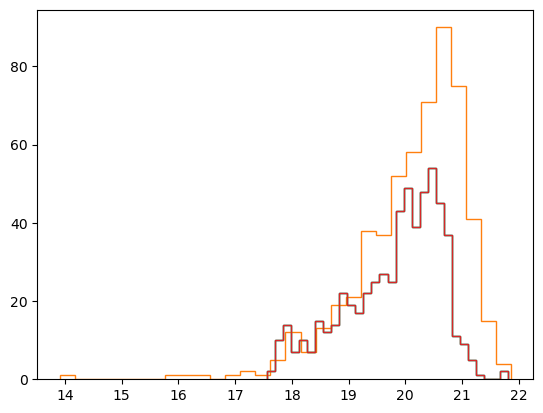

In [221]:
f = plt.hist(aces_matched['mag_auto_i'],histtype='step',bins=30)
f = plt.hist(vvds_deep_matched['mag_auto_i'],histtype='step',bins=30)
f = plt.hist(aces_matched['mag_auto_i'],histtype='step',bins=30)
f = plt.hist(aces_matched['mag_auto_i'],histtype='step',bins=30)

In [198]:
main = pd.concat([testing,training],axis=0)

In [194]:
main = main[main['#zs']<1.4]

In [200]:
min(main['#zs'])

-0.0007

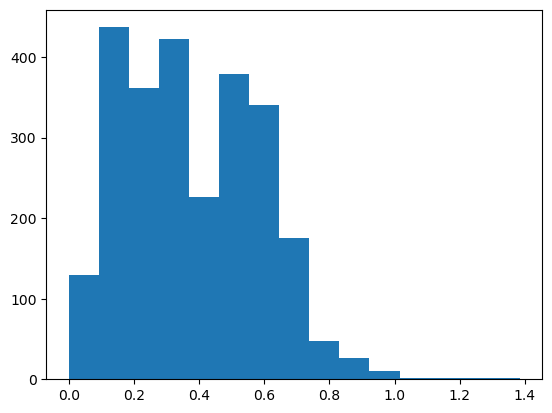

In [196]:
r = plt.hist(main['#zs'], bins = 15)

## Results analyses

In [204]:

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
df = pd.read_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/results/results.sanchez.0.mlz',names = column_names, header = None, skiprows =1, sep =' ')

zspec=df['ztrue']
zphot = df['zmean1']


In [208]:
# Calcula a estimativa de densidade usando kernel
kde = gaussian_kde([zspec, zphot])

# Define os limites do gráfico
x_min, x_max = min(zspec), max(zspec)
y_min, y_max = min(zphot), max(zphot)


In [209]:
# Cria uma grade de valores para o gráfico
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
z = kde(np.vstack([x.ravel(), y.ravel()]))


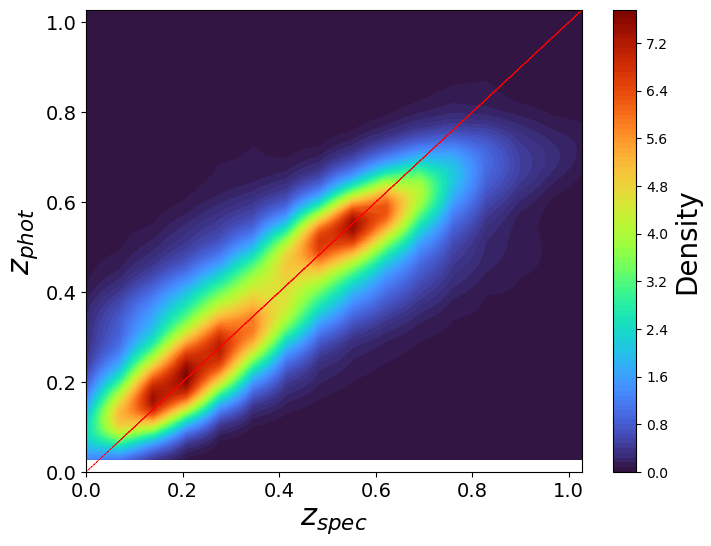

In [212]:
plt.figure(figsize=(8,6))



plt.plot(zspec,zspec,'r--', linewidth =0.5)


plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
colorbar = plt.colorbar()
colorbar.set_label('Density', fontsize=20)

plt.xlim(0, max(zphot))
plt.ylim(0, max(zphot))

plt.xlabel(r'$z_{spec}$', fontsize=22)
plt.ylabel(r'$z_{phot}$',fontsize=22)

plt.xticks(fontsize=14)  # Tamanho da fonte nos números do eixo x
plt.yticks(fontsize=14)


plt.show()


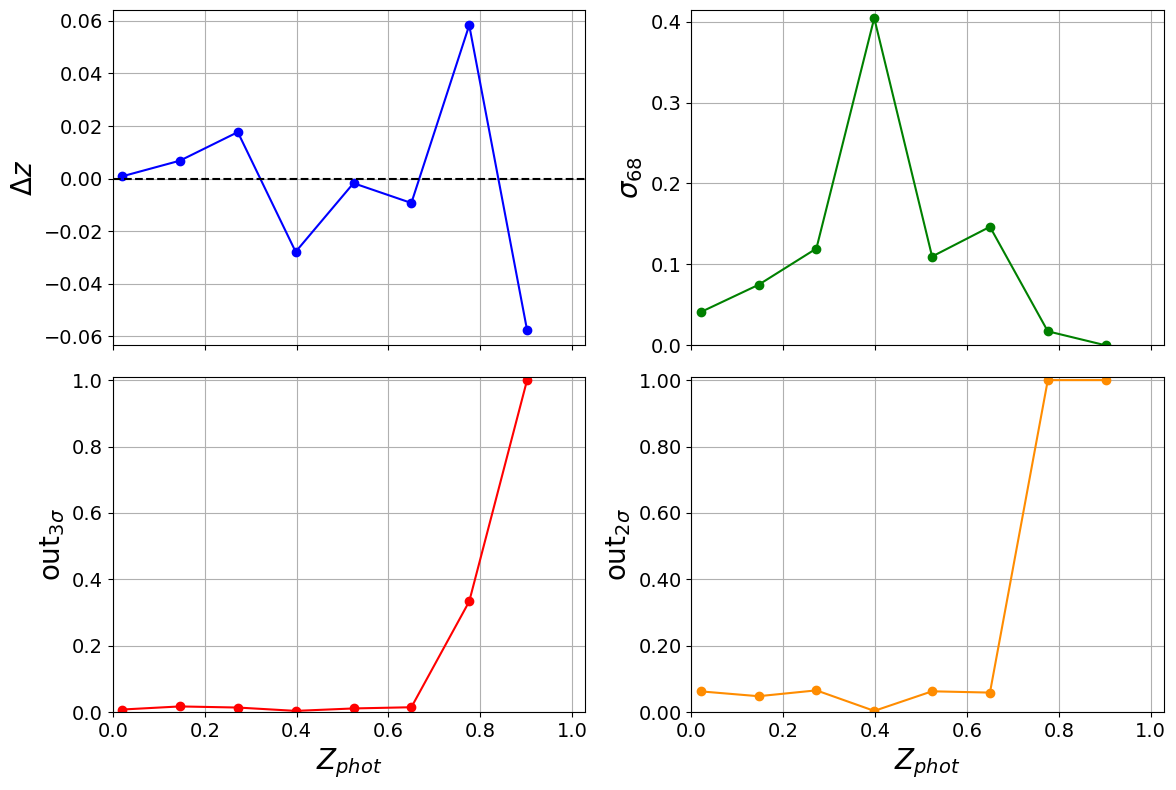

In [214]:
bins = np.linspace(0.02, np.max(zphot), 9)
fraction_outliers = []
sigmaz = []
meanz = []
outliers_2 = []

for index in range(len(bins) - 1):
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
    
    values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
    values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]

    deltabias = (values_r - values_s)
    mean_bias = np.mean(deltabias)  # Mean bias for each bin
    meanz.append(mean_bias)
    
    sigma = np.std(deltabias)  # Standard deviation (sigma) for each bin
    sigmaz.append(sigma)

    # Calculate the fraction of outliers outside 3 sigma
    outliers = np.abs(deltabias) > 3 * sigma
    fraction_outlier = np.sum(outliers) / len(outliers)
    
    fraction_outliers.append(fraction_outlier)
    
    #2 sigma
    outliers2 = np.abs(deltabias) > 2 * sigma
    fraction_outlier2 = np.sum(outliers2) / len(outliers2)
    
    
    outliers_2.append(fraction_outlier2)



fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
plt.subplots_adjust(hspace=0.4)  # Ajuste o espaço entre os subplots

# Configure os limites x comuns para todos os subplots
x_lim = (0, np.max(zphot))

# Subplot 1: Mean Bias
axes[0, 0].plot(bins[:-1], meanz, 'bo-')
axes[0, 0].axhline(0, color='black', linestyle='--')
axes[0, 0].set_ylabel(r'$\Delta z$', fontsize=20)
axes[0, 0].set_xlim(x_lim)
axes[0, 0].tick_params(axis='both', labelsize=14)
axes[0, 0].grid(True)

# Subplot 2: Standard Deviation
axes[0, 1].plot(bins[:-1], sigmaz, 'go-')
axes[0, 1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
axes[0, 1].set_xlim(x_lim)
axes[0, 1].set_ylim(0,max(sigmaz)+0.01)
axes[0, 1].tick_params(axis='both', labelsize=14)
axes[0, 1].grid(True)

# Subplot 3: Outliers
axes[1, 0].plot(bins[:-1], fraction_outliers, 'ro-')
axes[1, 0].set_xlabel(r'$Z_{phot}$', fontsize=20)
axes[1, 0].set_ylabel('out$_{3σ}$', fontsize=20)
axes[1, 0].set_xlim(x_lim)
axes[1, 0].set_ylim(0,max(fraction_outliers)+0.01)
axes[1, 0].tick_params(axis='both', labelsize=14)
axes[1, 0].grid(True)

# Subplot 4: 
axes[1, 1].plot(bins[:-1],outliers_2,'o-',color='darkorange')
axes[1, 1].set_xlabel(r'$Z_{phot}$', fontsize=20)
axes[1, 1].set_ylabel('out$_{2σ}$', fontsize=20)
axes[1, 1].set_xlim(x_lim)
axes[1, 1].set_ylim(0,max(outliers_2)+0.01)
axes[1, 1].tick_params(axis='both', labelsize=14)
axes[1, 1].grid(True)
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Ajuste o layout dos subplots
plt.tight_layout()


# Exiba a figura
plt.show()
